# Effect on Loan Outcomes based on Credit Rating and Other Factors
## by Chinnaporn Chinotaikul

## Investigation Overview

For this presentation, I want to look at the effect of loan outcome - whether it is successfully completed or if it fails to collect - based on various factors such as rating (including the factors that influence rating), loan term, size, and recommendations.

## Dataset Overview

The data set consists of 113,937 loans at Prosper from 2005 to 2014, with each row representing 1 loan. There are 81 variables, including identifiers and various properties of the loan as well as the borrower. I filtered the data to only include loans which have concluded and loans from 2011 onwards (in order to avoid effect of changing credit environment caused by the Subprime Crisis). 29,808 data points remained after cleaning.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Note: Jupyter Notebook created using Monokai dark theme from JupyterThemes package
# Format plots for dark background
from jupyterthemes import jtplot
jtplot.style('monokai')

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df_clean = pd.read_csv('cleaned_loan_data.csv')

## Distribution of Loan Outcomes

In the original data, loan outcomes are classified as Completed, Chargedoff and Default. Since the latter 2 both result in losses being recognised, I consider it the same result and combined them into a "Fail-to-collect" category. Approx. 78% of loans are successfully completed.

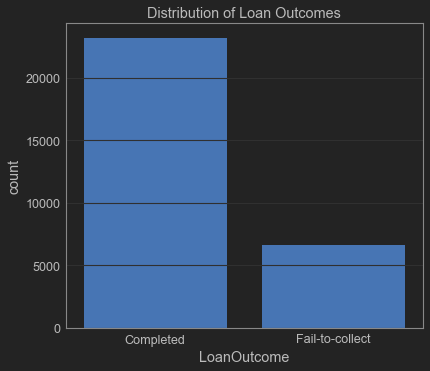

In [3]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.countplot(x=df_clean['LoanOutcome'], palette=sns.color_palette(n_colors=1),
              order=['Completed', 'Fail-to-collect'])
ax.set_title('Distribution of Loan Outcomes')
plt.show()

## Distribution of Prosper Rating

Prosper Rating is the propritary rating system used by the Prosper platform. Based on investigating, it appears to combine both conventional credit scoring inputs, which are the borrower's credit history (outstanding loans, credit amounts, debt-to-income ratio, etc.), as well as other factors such as the borrower's employment status. It ranges from 1 to 7 with 7 being the best. The most common rating is 3 while the least common is 7. The other values have approximately the same amounts.

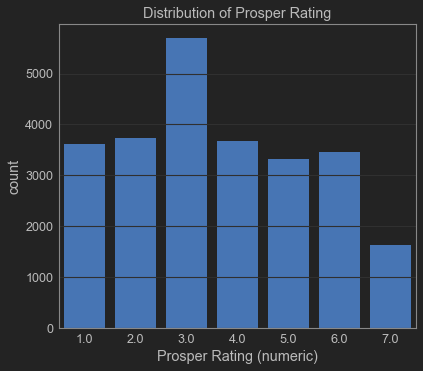

In [4]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.countplot(x=df_clean['ProsperRating (numeric)'],
              palette=sns.color_palette(n_colors=1))
ax.set_title('Distribution of Prosper Rating')
ax.set_xlabel('Prosper Rating (numeric)')

plt.show()

## Outcome vs Prosper Rating

Plotting outcome vs Prosper Rating shows that completed loans do tend to have higher average rating compared to loans that failed to collect. For both, the highest concentration of rating is 3, which is expected as it is the most common rating. For fail-to-collect loans, it is clear that the distribution of low ratings (1-2) is significantly higher than higher ratings (4-7). However, for completed loans, the distribution across all ratings is more flat.

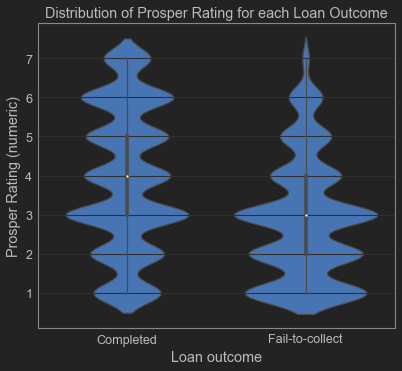

In [5]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.violinplot(data=df_clean, x='LoanOutcome',
               y='ProsperRating (numeric)', palette=sns.color_palette(n_colors=1),
               order=['Completed', 'Fail-to-collect'])
ax.set_title('Distribution of Prosper Rating for each Loan Outcome')
ax.set_xlabel('Loan outcome')
ax.set_ylabel('Prosper Rating (numeric)')

plt.show()

## Outcome vs Prosper Rating by Loan Terms

The terms of loans in the dataset consist only of 12-, 36- and 60-months. By plotting outcome vs rating and separating the charts by terms, some interesting observations can be made:
- The strongest relationship between rating and outcome appears to be at 36-month term, where the average rating for completed loans is 4, and fail-to-collect loans is 2. 12-month term seems to have a weaker relationship and 60-month term has the weakest relationship
- I think that the reason for 12-month being weaker is a combination of 2 factors: the loan being short-term means there is less potential for loans to default, and additionally it appears that 12-month loans are not given to borrowers with Prosper Rating of 1, making 12-month loans much less likely to default compared to 36-month
- It was surprising to see that the relationship for 60-month loan is very weak. In retrospect, it seems reasonable as for loans which are over 5 years long, credit scoring generated at the origination of the loan would likely have little prediction powers around the end of the loan's life.

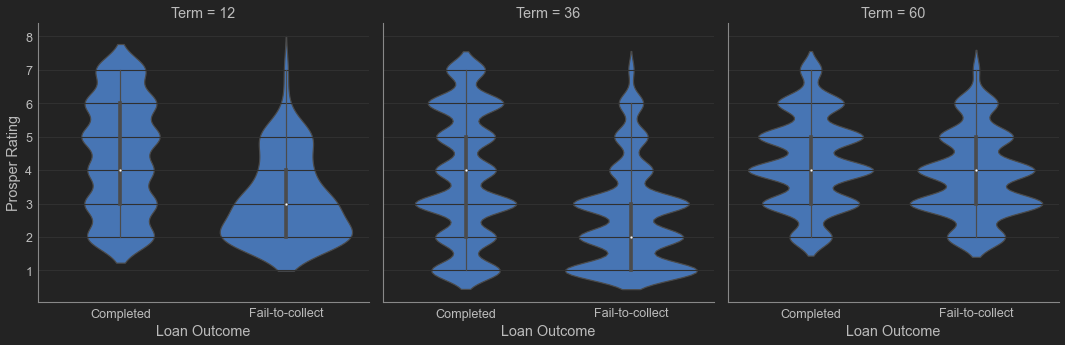

In [6]:
g = sns.FacetGrid(data=df_clean, col='Term', height=5,
                  margin_titles=True)
g.map(sns.violinplot, 'LoanOutcome', 'ProsperRating (numeric)', order=['Completed', 'Fail-to-collect'])
g.set_xlabels('Loan Outcome')
g.set_ylabels('Prosper Rating')

plt.show()

## Distribution of Loan Size

Before we move on to dividing the loans by loan size, we look at the range and distribution of loan sizes first.

For loan size, I normalise the loan size by the number of months, as there are several loan terms, I believe normalizing the size in terms of length of the loan would better reflect the expected performance of a loan (a USD 100 loan paid over 12 months would be more likely to default than USD 100 loan paid over 60 months).

The distribution of loan sizes in USD per month appears to follow a log-normal distribution.

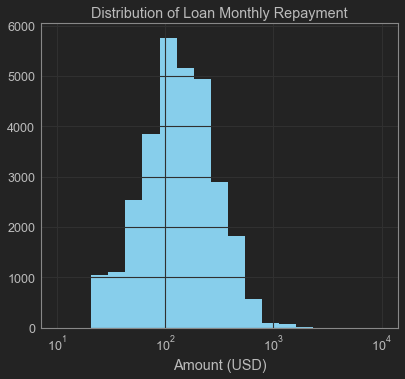

In [7]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.hist(df_clean['LoanAmountOverMonth'], color='skyblue',
         bins=np.logspace(np.log10(10.0), np.log10(10000.0), 20))
ax.set_title('Distribution of Loan Monthly Repayment')
ax.set_xscale('log')
ax.set_xlabel('Amount (USD)')
plt.show()

## Outcome vs Prosper Rating by Loan Size

I allocate the loans to 9 bins based on their sizes in USD per month.

As seen in the grouped violin plot below, as the loan size gets larger, the average rating tends to get larger which makes sense as those with better ratings are more likely to get larger loans. For most bins, the previously observed relationship between rating and outcome appears to hold true.

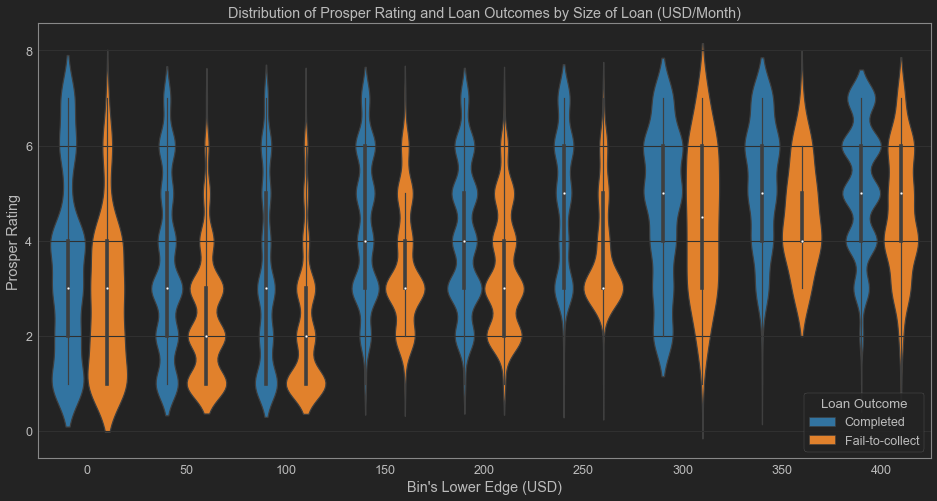

In [8]:
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
sns.violinplot(data=df_clean, x='SizeGroup', y='ProsperRating (numeric)', hue='LoanOutcome',
               palette=sns.color_palette('tab10', n_colors=2),
               hue_order=['Completed', 'Fail-to-collect'])
ax.set_title(
    'Distribution of Prosper Rating and Loan Outcomes by Size of Loan (USD/Month)')
ax.set_xlabel('Bin\'s Lower Edge (USD)')
ax.set_ylabel('Prosper Rating')
ax.legend(title='Loan Outcome', loc='lower right')

plt.show()

## Outcome vs Prosper Rating by Recommendations

Each borrower can have recommendations by other Prosper users. The vast majority of users have 0 recommendations. Some have 1-2 recommendations but 3 and above are very rare.

Based on my investigation, while having more recommendations appear to increasingly improve the probability of a loan's successful outcome, the very small number of >2 recommendations makes it not very meaningful. Therefore, I have simplified this variable by seperating into 2 groups, "No recommendation" and "Has recommendation".

It does not appear that Prosper Rating takes into account the number of recommendations, and a borrower having recommendation significantly improves the loan's expected performance across all Prosper Rating groups, with the most improvement seen at the lower values of rating.

In [9]:
recc_heatmap = pd.DataFrame(index=np.arange(1, 8, dtype='int'),
                            columns=np.arange(0, 19, dtype='int'))

for index, row in recc_heatmap.iterrows():
    for num_recc in np.arange(0, recc_heatmap.shape[1]):
        completed = ((df_clean['LoanOutcome'] == 'Completed') &
                     (df_clean['Recommendations'] == num_recc) &
                     (df_clean['ProsperRating (numeric)'] == index)).sum()
        total = ((df_clean['Recommendations'] == num_recc) &
                 (df_clean['ProsperRating (numeric)'] == index)).sum()
        if total != 0:
            recc_heatmap.loc[index, num_recc] = completed / total

recc_heatmap = recc_heatmap.astype('float')

In [10]:
recc_heatmap_simplify = pd.DataFrame()
recc_heatmap_simplify['No_recommendation'] = recc_heatmap[0]

for index, row in recc_heatmap_simplify.iterrows():
    completed = ((df_clean['LoanOutcome'] == 'Completed') &
                 (df_clean['Recommendations'] > 0) &
                 (df_clean['ProsperRating (numeric)'] == index)).sum()
    total = ((df_clean['Recommendations'] > 0) &
             (df_clean['ProsperRating (numeric)'] == index)).sum()
    if total != 0:
        recc_heatmap_simplify.loc[index, 'Has_recommendation'] = completed / total

recc_heatmap_simplify = recc_heatmap_simplify.astype('float')

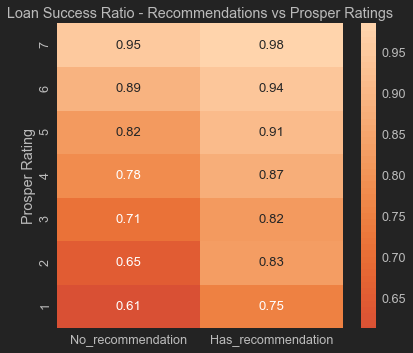

In [11]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
sns.heatmap(recc_heatmap_simplify, annot=True, fmt='.2f', center=0)
ax.set_ylabel('Prosper Rating')
ax.invert_yaxis()
ax.set_title(
    'Loan Success Ratio - Recommendations vs Prosper Ratings')

plt.show()